# **Second Iteration of Home Price Prediction Notebook** #
Trained 5 models on different folds of data with RandomForestRegressor
Performed worse than before

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml/blob/master/01_the_machine_learning_landscape.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## **Setup**

In [1]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [2]:
%cd drive/MyDrive/kaggle-home-prices/

/content/drive/MyDrive/kaggle-home-prices


In [3]:
import numpy as np
import os
import pandas as pd
import sklearn
import seaborn as sns
from xgboost import XGBRegressor


## **Load Data**

In [4]:
os.chdir("data")

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [6]:
from sklearn.model_selection import train_test_split
practice_train_set, practice_test_set = train_test_split(train, test_size=0.2, random_state=42)

## **EDA**

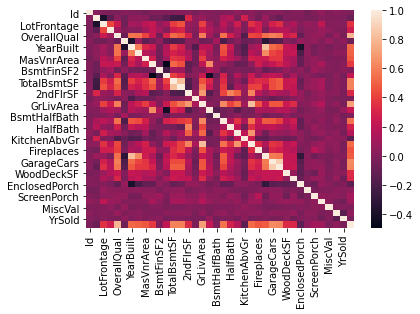

In [ ]:
sns.heatmap(train.corr())

In [ ]:
train.info()

# **Transformers**

In [8]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold


class DataFrameSelector(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
  def fit(self, X, y=None):
    return self  
  def transform(self, X):
    return X[self.attribute_names].values  

y = train["SalePrice"].copy()
X = train.drop("SalePrice", axis=1)

num_attribs = list(X.select_dtypes(exclude='object').keys())
cat_attribs = list(X.select_dtypes(include='object').keys())


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def prepare_data(train_index, valid_index):
  X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
  y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
  X_test = test.copy()

  num_pipeline= Pipeline([('selector', DataFrameSelector(num_attribs)), ('imputer', SimpleImputer(strategy='median')), ('std_scaler', StandardScaler()), ('feature_selector', SelectFromModel(RandomForestRegressor(), threshold=-np.inf, max_features=10)), ])
  cat_pipeline= Pipeline([('selector', DataFrameSelector(cat_attribs)), ('imputer', CategoricalImputer()), ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

  full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline), ("cat_pipeline", cat_pipeline),])

  X_train_prepared = full_pipeline.fit_transform(X_train, y_train)
  X_valid_prepared = full_pipeline.fit_transform(X_valid, y_valid)
  X_test_prepared = full_pipeline.transform(X_test)

  return (X_train_prepared, X_valid_prepared, X_test_prepared, y_train, y_valid)
  

In [9]:
y_practice = practice_train_set["SalePrice"].copy()
X_practice = practice_train_set.drop("SalePrice", axis=1)
y_practice_test = practice_test_set["SalePrice"].copy()
X_practice_test = practice_test_set.drop("SalePrice", axis=1)

num_pipeline= Pipeline([('selector', DataFrameSelector(num_attribs)), ('imputer', SimpleImputer(strategy='median')), ('std_scaler', StandardScaler()), ('feature_selector', SelectFromModel(RandomForestRegressor(), threshold=-np.inf, max_features=10)), ])
cat_pipeline= Pipeline([('selector', DataFrameSelector(cat_attribs)), ('imputer', CategoricalImputer()), ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore')), ])
full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline), ("cat_pipeline", cat_pipeline),])

X_train = full_pipeline.fit_transform(X_practice, y_practice)
X_test = full_pipeline.transform(X_practice_test)

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
              {'n_estimators': [80, 100, 120, 140], 'max_features': [14, 16, 18, 20]},
              {'bootstrap': [False], 'n_estimators': [3,10, 30], 'max_features':[2, 3, 4, 5 , 6]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_practice)
print(grid_search.best_estimator_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=20, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=140, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

model = grid_search.best_estimator_
preds = model.predict(X_test)
lin_mse = mean_squared_error(y_practice_test, preds)
lin_rmse = np.sqrt(lin_mse)
print("RMSE", lin_rmse)
lin_log_mse = mean_squared_error(np.log(y_practice_test), np.log(preds))
lin_log_rmse = np.sqrt(lin_log_mse)
print("log rmse", lin_log_rmse)

RMSE 32631.21681816682
log rmse 0.16867934879359844


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
final_test_predictions = []
final_valid_predictions = {}
scores = []
for fold, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print(train_index, valid_index)
    X_train, X_valid, X_test, y_train, y_valid = prepare_data(train_index, valid_index)
    model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse', 
                      max_depth=None, max_features=18, max_leaf_nodes=None, 
                      max_samples=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, min_samples_leaf=1, 
                      min_samples_split=2, min_weight_fraction_leaf=0.0, 
                      n_estimators=80, n_jobs=None, oob_score=False, 
                      random_state=None, verbose=0, warm_start=False) 
    model.fit(X_train, y_train)
    preds_valid = model.predict(X_valid)
    test_preds = model.predict(X_test)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_index, preds_valid)))
    rmse = mean_squared_error(y_valid, preds_valid, squared=False)
    print(fold, rmse)
    scores.append(rmse)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_1"]
final_valid_predictions.to_csv("../submissions/train_pred_0.csv", index=False)

# a = np.arange(np.size(final_test_predictions[0]))
b = np.mean(np.column_stack(final_test_predictions), axis=1)
# np_data =  np.stack((a, b), axis=1)
# df = pd.DataFrame(data = np_data, columns = ['d','SalePrice'])
# df.info()

import csv

# open the file in the write mode
f = open('../submissions/test_pred_0.csv', 'w')
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(["Id", "SalePrice"])
for count, id in enumerate(test["Id"]):
   writer.writerow([id, b[count]])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[   1    2    4 ... 1457 1458 1459] [   0    3    7    9   12   16   17   27   45   54   57   73   76   78
   84   85   87   89   96   97  108  110  124  125  126  127  130  134
  138  142  144  145  146  151  157  159  164  165  178  180  183  189
  194  195  199  202  204  211  213  227  231  238  242  243  246  247
  249  252  254  257  259  264  276  279  280  282  286  287  290  298
  300  303  307  308  312  314  319  323  328  331  332  340  341  343
  351  353  373  374  377  390  391  397  403  409  413  414  422  425
  430  441  444  447  451  463  470  476  480  494  497  507  515  523
  525  535  538  543  545  560  562  563  572  573  578  583  586  590
  593  594  595  599  604  605  611  613  620  622  624  627  630  637
  642  646  647  658  659  664  672  678  686  696  706  712  716  730
  732  735  738  740  745  753  755  761  765  772  775  777  787  796
  797  802  806  812  814  817  823  834  840  841  843  844  846  851
  853  858  861  866  890  896  903  906 

In [ ]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
train_set_labels = train_set["SalePrice"].copy()
new_train = train_set.drop("SalePrice", axis=1)
train_set_prepared = full_pipeline.fit_transform(train_set, train_set_labels)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=train_set_prepared):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)



In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor


param_grid = [
              {'n_estimators': [80, 100, 120, 140], 'max_features': [14, 16, 18, 20], 'max_depth': [10, 15, 20], 'learning_rate': [0.01, 0.1, 1]},
              {'n_estimators': [3,10, 30], 'max_features':[2, 3, 4, 5 , 6]},
]
forest_reg = GradientBoostingRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

y = train["SalePrice"].copy()
X = train.drop("SalePrice", axis=1)
grid_search.fit(X, y)
model = grid_search.best_estimator_
print(cv_rmse(model))

preds = model.predict(test)
lin_mse = mean_squared_error(practice_test_labels, preds)
lin_rmse = np.sqrt(lin_mse)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor


param_grid = [
              {'n_estimators': [80, 100, 120, 140], 'max_features': [14, 16, 18, 20], 'max_depth': [10, 15, 20], 'learning_rate': [0.01, 0.1, 1]},
              {'n_estimators': [3,10, 30], 'max_features':[2, 3, 4, 5 , 6]},
]
forest_reg = GradientBoostingRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(practice_train_set_prepared, labels)

print(grid_search.best_estimator_)
feature_importances = grid_search.best_estimator_.feature_importances_
lin_reg = grid_search.best_estimator_

test_sale_price_dropped = practice_train_set.drop("SalePrice", axis=1)
practice_test_labels = practice_train_set["SalePrice"].copy()
practice_test_set_prepared = full_pipeline.transform(test_sale_price_dropped)
practice_data_predictions = lin_reg.predict(practice_test_set_prepared)

from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(practice_test_labels, practice_data_predictions)
lin_rmse = np.sqrt(lin_mse)
# for i, p in enumerate(practice_test_set["SalePrice"]):
#   print(practice_data_predictions[i], p)
print("RMSE", lin_rmse)

l = np.sort(feature_importances)
print(l)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 494767131484.4592, tolerance: 537415025.1745832
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 435766171175.8299, tolerance: 572016182.2224231
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341114784851.29407, tolerance: 525605188.80204767
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5015848528

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
RMSE 33467.8292845672
[0.00000000e+00 5.43333071e-04 6.05159552e-04 2.71551777e-03
 3.29291232e-03 5.27363790e-03 6.57638182e-03 7.10427186e-03
 8.53668059e-03 9.37831216e-03 1.46304960e-02 1.99391448e-02
 2.60853393e-02 2.89922786e-02 3.70514053e-02 4.14459883e-02
 4.64732158e-02 5.54482962e-02 1.39388890e-01 5.46518739e-01]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
train_set_labels = train_set["SalePrice"].copy()
new_train = train_set.drop("SalePrice", axis=1)
train_set_prepared = full_pipeline.fit_transform(train_set, train_set_labels)


param_grid = [
              {'alpha': [0.001, 0.01, 0.1]}
]
lasso_reg = Lasso()
grid_search = GridSearchCV(lasso_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_set_prepared, train_set_labels)

print(grid_search.best_estimator_)

feature_importances = grid_search.best_estimator_.feature_importances_
lin_reg = grid_search.best_estimator_


test_set_prepared = full_pipeline.transform(test_set)
final_predictions = lin_reg.predict(test_set_prepared)

print(final_predictions)


import csv

# open the file in the write mode
f = open('submission.csv', 'w')
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(["Id", "SalePrice"])
for count, id in enumerate(test_set["Id"]):
   writer.writerow([id, final_predictions[count]])


# close the file
f.close()   

GradientBoostingRegressor(alpha=0.1, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
[131466.80247101 165110.67543194 173263.28928813 ... 153699.81387269
 124934.55985653 226272.40056187]
